Epoch [1/30], Step [100/1875], Loss: 1.2614
Epoch [1/30], Step [200/1875], Loss: 0.8274
Epoch [1/30], Step [300/1875], Loss: 0.7395
Epoch [1/30], Step [400/1875], Loss: 0.6577
Epoch [1/30], Step [500/1875], Loss: 0.6431
Epoch [1/30], Step [600/1875], Loss: 0.5905
Epoch [1/30], Step [700/1875], Loss: 0.5754
Epoch [1/30], Step [800/1875], Loss: 0.5333
Epoch [1/30], Step [900/1875], Loss: 0.5938
Epoch [1/30], Step [1000/1875], Loss: 0.5181
Epoch [1/30], Step [1100/1875], Loss: 0.4765
Epoch [1/30], Step [1200/1875], Loss: 0.4896
Epoch [1/30], Step [1300/1875], Loss: 0.4693
Epoch [1/30], Step [1400/1875], Loss: 0.4591
Epoch [1/30], Step [1500/1875], Loss: 0.4857
Epoch [1/30], Step [1600/1875], Loss: 0.4350
Epoch [1/30], Step [1700/1875], Loss: 0.4373
Epoch [1/30], Step [1800/1875], Loss: 0.4462
Epoch [1/30] Training Accuracy: 78.64%
Epoch [1/30] Validation Accuracy: 84.85%
Epoch [2/30], Step [100/1875], Loss: 0.4207
Epoch [2/30], Step [200/1875], Loss: 0.4436
Epoch [2/30], Step [300/1875], 

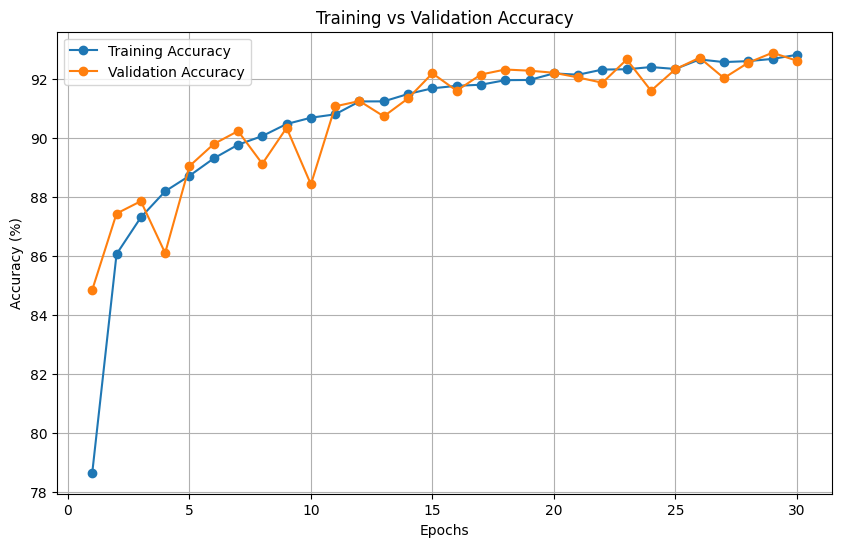

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from math import ceil
import matplotlib.pyplot as plt

# Dataset transformations for FashionMNIST
transform_train = transforms.Compose([
    transforms.Resize((240, 240)),  # Resize images to match EfficientNet-B1 resolution
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # FashionMNIST is grayscale, mean=0.5, std=0.5
])

transform_val = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Define EfficientNet model with the main blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()
        self.cnnblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )

    def forward(self, x):
        return self.cnnblock(x)

class MBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, ratio, reduction=2):
        super(MBBlock, self).__init__()
        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1)

        self.conv = nn.Sequential(
            ConvBlock(hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, inputs):
        if self.expand:
            x = self.expand_conv(inputs)
        else:
            x = inputs
        return self.conv(x)

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class EfficientNet(nn.Module):
    def __init__(self, model_name, output):
        super(EfficientNet, self).__init__()
        basic_mb_params = [
            [1, 16, 1, 1, 3],
            [6, 24, 2, 2, 3],
            [6, 40, 2, 2, 5],
            [6, 80, 3, 2, 3],
            [6, 112, 3, 1, 5],
            [6, 192, 4, 2, 5],
            [6, 320, 1, 1, 3],
        ]
        alpha, beta = 1.2, 1.1
        scale_values = {
            "b0": (0, 224, 0.2),
            "b1": (0.5, 240, 0.2),
            "b2": (1, 260, 0.3),
            "b3": (2, 300, 0.3),
            "b4": (3, 380, 0.4),
            "b5": (4, 456, 0.4),
            "b6": (5, 528, 0.5),
            "b7": (6, 600, 0.5),
        }
        phi, resolution, dropout = scale_values[model_name]
        self.depth_factor, self.width_factor = alpha * phi, beta * phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.feature_extractor(basic_mb_params)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.last_channels, output),
        )

    def feature_extractor(self, basic_mb_params):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(1, channels, 3, stride=2, padding=1)]  # Changed to grayscale input (1 channel)
        in_channels = channels

        for k, c_o, repeat, s, n in basic_mb_params:
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                stride = s if layer == 0 else 1
                features.append(
                    MBBlock(in_channels, out_channels, ratio=k, stride=stride, kernel_size=n, padding=n // 2)
                )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels, self.last_channels, kernel_size=1, stride=1, padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        return self.classifier(self.flatten(x))


# Initialize the model for FashionMNIST
model_name = 'b1'
output_class = 10  # FashionMNIST has 10 classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effnet = EfficientNet(model_name, output_class).to(device)

def train_model(model, train_loader, val_loader, epochs=30, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}] Training Accuracy: {train_accuracy:.2f}%')

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}] Validation Accuracy: {val_accuracy:.2f}%')

    # Plot the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


# Train the model and plot the results
train_model(effnet, train_loader, val_loader, epochs=30)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.83MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



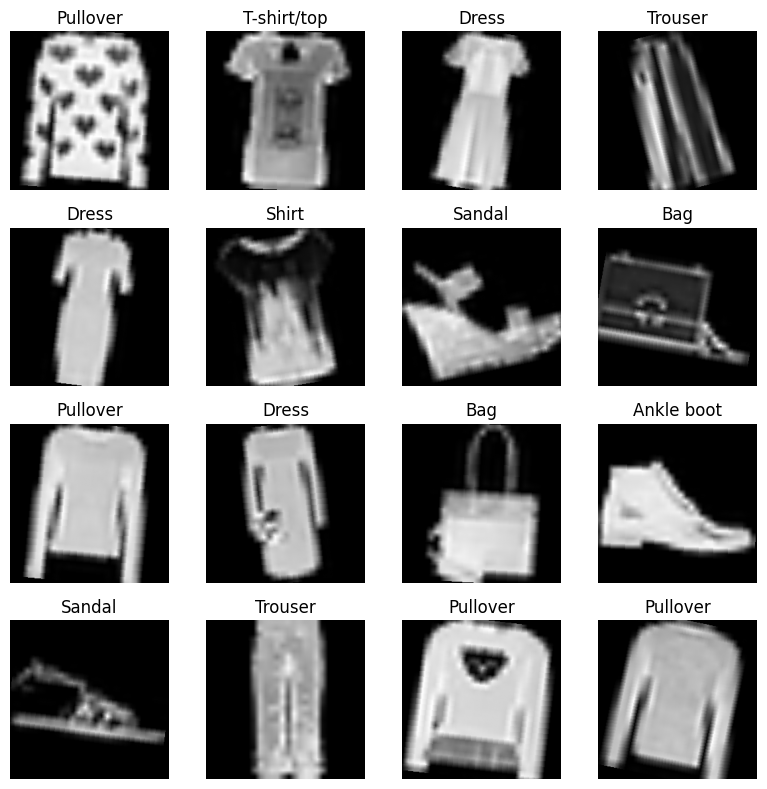

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from math import ceil
import matplotlib.pyplot as plt

# Dataset transformations for FashionMNIST
transform_train = transforms.Compose([
    transforms.Resize((240, 240)),  # Resize images to match EfficientNet-B1 resolution
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # FashionMNIST is grayscale, mean=0.5, std=0.5
])

transform_val = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Define EfficientNet model (using the provided implementation)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()
        self.cnnblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )

    def forward(self, x):
        return self.cnnblock(x)

class MBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, ratio, reduction=2):
        super(MBBlock, self).__init__()
        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1)

        self.conv = nn.Sequential(
            ConvBlock(hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, inputs):
        if self.expand:
            x = self.expand_conv(inputs)
        else:
            x = inputs
        return self.conv(x)

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class EfficientNet(nn.Module):
    def __init__(self, model_name, output):
        super(EfficientNet, self).__init__()
        basic_mb_params = [
            [1, 16, 1, 1, 3],
            [6, 24, 2, 2, 3],
            [6, 40, 2, 2, 5],
            [6, 80, 3, 2, 3],
            [6, 112, 3, 1, 5],
            [6, 192, 4, 2, 5],
            [6, 320, 1, 1, 3],
        ]
        alpha, beta = 1.2, 1.1
        scale_values = {
            "b0": (0, 224, 0.2),
            "b1": (0.5, 240, 0.2),
            "b2": (1, 260, 0.3),
            "b3": (2, 300, 0.3),
            "b4": (3, 380, 0.4),
            "b5": (4, 456, 0.4),
            "b6": (5, 528, 0.5),
            "b7": (6, 600, 0.5),
        }
        phi, resolution, dropout = scale_values[model_name]
        self.depth_factor, self.width_factor = alpha * phi, beta * phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.feature_extractor(basic_mb_params)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.last_channels, output),
        )

    def feature_extractor(self, basic_mb_params):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(1, channels, 3, stride=2, padding=1)]  # Changed to grayscale input (1 channel)
        in_channels = channels

        for k, c_o, repeat, s, n in basic_mb_params:
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                stride = s if layer == 0 else 1
                features.append(
                    MBBlock(in_channels, out_channels, ratio=k, stride=stride, kernel_size=n, padding=n // 2)
                )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels, self.last_channels, kernel_size=1, stride=1, padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        return self.classifier(self.flatten(x))


# Initialize the model for FashionMNIST
model_name = 'b1'
output_class = 10  # FashionMNIST has 10 classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effnet = EfficientNet(model_name, output_class).to(device)

def train_model(model, train_loader, val_loader, epochs=30, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}] Training Accuracy: {train_accuracy:.2f}%')

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}] Validation Accuracy: {val_accuracy:.2f}%')

    # Plot the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


# Train the model and plot the results
#train_model(effnet, train_loader, val_loader, epochs=30)

# Visualize a batch of training images
def show_batch(data_loader, classes):
    batch = next(iter(data_loader))
    images, labels = batch
    grid_size = 4  # Display 4x4 grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

    for i in range(grid_size * grid_size):
        row, col = divmod(i, grid_size)
        axes[row, col].imshow(images[i][0], cmap='gray')  # Grayscale images
        axes[row, col].set_title(classes[labels[i].item()])
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Define class names for FashionMNIST
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Show a batch of training data
show_batch(train_loader, classes)


Model loaded successfully.


<ipython-input-9-c62500c11d0c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  effnet.load_state_dict(torch.load('efficientnet_fashionmnist.pth'))


Prediction: Ankle boot, True Label: Ankle boot
Prediction: Pullover, True Label: Pullover
Prediction: Trouser, True Label: Trouser
Prediction: Trouser, True Label: Trouser
Prediction: Shirt, True Label: Shirt
Prediction: Trouser, True Label: Trouser
Prediction: Coat, True Label: Coat
Prediction: Shirt, True Label: Shirt
Prediction: Sandal, True Label: Sandal
Prediction: Sneaker, True Label: Sneaker


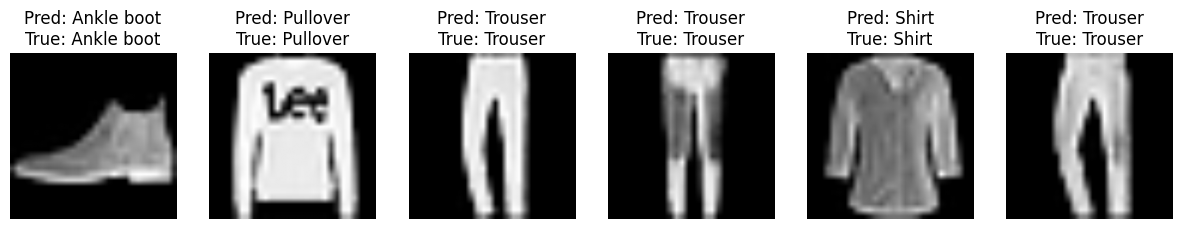

AttributeError: 'NoneType' object has no attribute 'data'

<Figure size 1500x1500 with 0 Axes>

In [ ]:
# Class names for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Load the model for prediction
effnet.load_state_dict(torch.load('efficientnet_fashionmnist.pth'))
effnet.eval()  # Set model to evaluation mode
print("Model loaded successfully.")

# Function to predict on validation set with class names
def predict_on_validation(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())  # Collect predictions
            true_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Convert numeric labels to class names
    predictions = [class_names[p] for p in predictions]
    true_labels = [class_names[t] for t in true_labels]

    # Return predictions and true labels
    return predictions, true_labels

# Get predictions and true labels from the validation set
predictions, true_labels = predict_on_validation(effnet, val_loader)

# Example: Print the first 10 predictions and true labels
for i in range(10):
    print(f"Prediction: {predictions[i]}, True Label: {true_labels[i]}")

# Visualize predictions with class names
def visualize_predictions(predictions, true_labels, val_loader, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        image, label = val_loader.dataset[i]
        plt.subplot(1, num_images, i+1)
        plt.imshow(image.squeeze(0).numpy(), cmap='gray')
        plt.title(f"Pred: {predictions[i]}\nTrue: {true_labels[i]}")
        plt.axis('off')
    plt.show()

# Visualize the first 5 predictions
visualize_predictions(predictions, true_labels, val_loader, num_images=6)



Model loaded successfully.
Predicted Class: Bag


<ipython-input-7-88bcc4996368>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  effnet.load_state_dict(torch.load('efficientnet_fashionmnist.pth'))


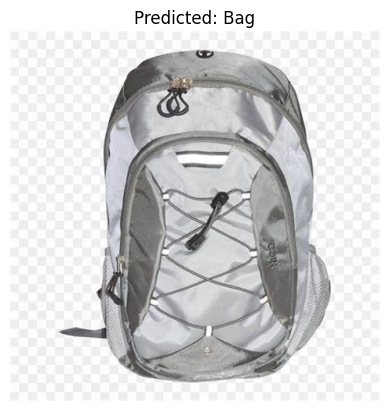

In [ ]:
# Load the model for prediction
effnet.load_state_dict(torch.load('efficientnet_fashionmnist.pth'))
effnet.eval()  # Set model to evaluation mode
print("Model loaded successfully.")
from PIL import Image

# Define transformation for the input image
transform_test = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform_test(image).unsqueeze(0)  # Add batch dimension
    return image
# Predict on a single image
def predict_image(image_path, model, class_names):
    model.eval()
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return class_names[predicted.item()]

# Define class names for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


image_path = "bag2.jfif"
predicted_class = predict_image(image_path, effnet, class_names)
print(f'Predicted Class: {predicted_class}')
def display_prediction(image_path, predicted_class):
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Display the image and prediction
display_prediction(image_path, predicted_class)


<ipython-input-19-b2ab62a90a71>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  effnet.load_state_dict(torch.load('efficientnet_fashionmnist.pth', map_location=device))


Original Prediction: Bag
Adversarial Prediction: Sandal


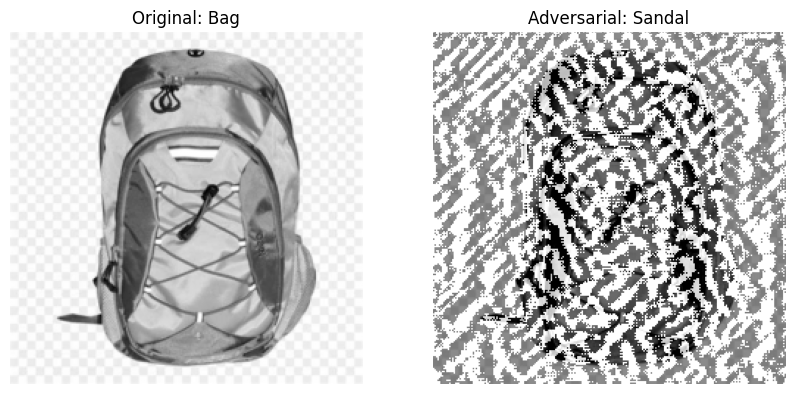

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
effnet.load_state_dict(torch.load('efficientnet_fashionmnist.pth', map_location=device))
effnet.to(device)
effnet.eval()

# Define transformation for preprocessing
transform_test = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Function to preprocess image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform_test(image).unsqueeze(0).to(device)  # Add batch dimension
    return image

# FGSM Attack Function
def fgsm_attack(model, image, epsilon, target_class=None):
    image.requires_grad = True
    output = model(image)

    # Choose target class for a targeted attack (optional)
    if target_class is not None:
        target = torch.tensor([target_class], device=device)
        loss = F.cross_entropy(output, target)  # Force model to predict target class
    else:
        loss = -F.cross_entropy(output, output.max(1)[1])  # Maximize wrong class probability

    # Compute gradients
    model.zero_grad()
    loss.backward()

    # Apply small perturbation
    sign_data_grad = image.grad.data.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)

    return perturbed_image.detach()  # Detach from computation graph

# Function to predict an image
def predict_image(image, model, class_names):
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return class_names[predicted.item()]

# Define class names for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Load and process the original image
image_path = "bag2.jfif"
original_image = preprocess_image(image_path)

# Predict original class
original_prediction = predict_image(original_image, effnet, class_names)
print(f'Original Prediction: {original_prediction}')

# Apply FGSM attack with small epsilon
epsilon = 0.9 # Adjust epsilon for stronger/weaker attack
perturbed_image = fgsm_attack(effnet, original_image, epsilon)

# Predict adversarial class
perturbed_prediction = predict_image(perturbed_image, effnet, class_names)
print(f'Adversarial Prediction: {perturbed_prediction}')

# Display original and perturbed images
def display_images(original, perturbed, orig_label, adv_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Convert tensors to numpy for visualization
    original = original.cpu().squeeze().detach().numpy()
    perturbed = perturbed.cpu().squeeze().detach().numpy()

    axs[0].imshow(original, cmap='gray')
    axs[0].set_title(f'Original: {orig_label}')
    axs[0].axis('off')

    axs[1].imshow(perturbed, cmap='gray')
    axs[1].set_title(f'Adversarial: {adv_label}')
    axs[1].axis('off')

    plt.show()

display_images(original_image, perturbed_image, original_prediction, perturbed_prediction)
